# MobileNet v2

- Paper: [2018.01.13] MobileNetV2; Inverted Residuals and Linear Bottlenecks
- https://arxiv.org/abs/1801.04381

### [Package load]

In [ ]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

### [Model: MobileNet v2]

- https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py

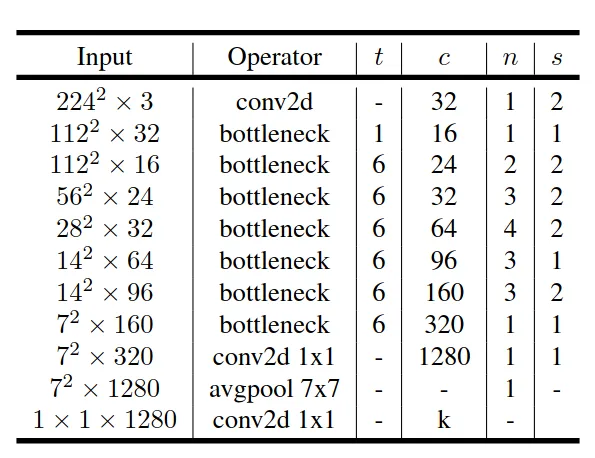

In [ ]:
def _make_divisible(v, divisor, min_value = None):
    # 각 channel 수가 나눠질 수 있도록 숫자를 변환시키는 역할
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvNormReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size = 3, groups = 1, stride = 1):
        padding = (kernel_size - 1) // 2
        super(ConvNormReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size = kernel_size, padding = padding, groups=groups, stride = stride),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
            )


class BottleNeck(nn.Module):
    def __init__(self, input_dim, output_dim, stride, expand_ratio=6):
        super().__init__()
        
        self.stride = stride
        
        self.use_res_connect = self.stride == 1 and input_dim == output_dim
            # stride = 1이고 input output channel 수가 같아야 residual connection 사용함
        
        hidden_dim = int(round(input_dim * expand_ratio))
        
        layers = []
        if expand_ratio != 1:
            # Pointwise convolution (expane_ratio가 1이면 의미 없으니 1이 아닐 때만 추가!)
            layers.append(ConvNormReLU(input_dim, hidden_dim, kernel_size=1))
        layers.extend([ConvNormReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),   # depthwise convolution
        nn.Conv2d(hidden_dim, output_dim, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(output_dim)]  # 마지막에는 ReLU가 없음
        )

        self.conv = nn.Sequential(*layers)      # list를 풀어서 sequential로 넣기
        self.output_channel = output_dim
    
    def forward(self, x):
        # use_res_connect가 True인 경우만 residual connection 사용
        # use_res_connect : stride가 1이고 input과 output의 채널 수가 같은 경우 True
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes, alpha=1.0, inverted_residual_setting = None, round_nearest=8, block= None, dropout=0.2):
        # alpha = width multiplier (0, 1] -> Width를 줄여주는 효과 = model을 더 축소시키는 효과
        super(MobileNetV2, self).__init__()
        
        if block is None:
            block = BottleNeck
        
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
                # t, c, n, s (순서대로) (t: expansion factor, c: output channel, n: 반복, s: stride)
            ]
        
        # 첫 layer 만들기
        input_channel = _make_divisible(input_channel * alpha, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, alpha), round_nearest)
        features = [ConvNormReLU(3, input_channel, stride=2)]

        # 이후 layer 쌓기
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * alpha, round_nearest)
                    # alpha는 output_channel 줄이는 역할 -> 이게 1이 아니면 _make_divisible이 효과를 보게 된다
            # n번 반복
            for i in range(n):
                stride = s if i == 0 else 1     # The first layer of each sequence has a stride s and all others use stride 1.
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        
        # 마지막 몇 개 layer 쌓기
        features.append(ConvNormReLU(input_channel, self.last_channel, kernel_size=1))  # conv2d 1x1

        # nn.Sequential로 feature list를 묶기
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
mobilenet_v2 = MobileNetV2(num_classes=4).to(device)

In [ ]:
mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): ConvNormReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): BottleNeck(
      (conv): Sequential(
        (0): ConvNormReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): BottleNeck(
      (conv): Sequential(
        (0): ConvNormReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2

In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
mobilenet_v2(temp)

tensor([[ 0.0164, -0.0524,  0.1030, -0.3367]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchsummary import summary
summary(mobilenet_v2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             320
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
        BottleNeck-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,632
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             960
      BatchNorm2d-14           [-1, 96,

In [ ]:
from torchinfo import summary
summary(mobilenet_v2, input_size=(1, 3, 224, 224), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                  Input Shape          Kernel Shape         Output Shape         Param %
MobileNetV2 (MobileNetV2)                          [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (features): 1-1                       [1, 3, 224, 224]     --                   [1, 1280, 7, 7]           --
│    └─ConvNormReLU (0): 2-1                       [1, 3, 224, 224]     --                   [1, 32, 112, 112]         --
│    │    └─Conv2d (0): 3-1                        [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]      0.04%
│    │    └─BatchNorm2d (1): 3-2                   [1, 32, 112, 112]    --                   [1, 32, 112, 112]      0.00%
│    │    └─ReLU6 (2): 3-3                         [1, 32, 112, 112]    --                   [1, 32, 112, 112]         --
│    └─BottleNeck (1): 2-2                         [1, 32, 112, 112]    --                   [1, 16, 112, 112]         --
│    │    └─Sequential (

### [Model: MobileNet v2 Transfer Learning]

- https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v2.html#torchvision.models.mobilenet_v2

In [ ]:
class TransferMobileNetV2(nn.Module):
    def __init__ (self, num_classes):
        super(TransferMobileNetV2, self).__init__()
        self.mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
        num_feature = torchvision.models.mobilenet_v2(pretrained=True).classifier[1].in_features
        self.mobilenet_v2.classifier[1] = nn.Linear(num_feature, num_classes)
        
    def forward(self,x):
        return self.mobilenet_v2(x)

In [ ]:
mobilenetv2_transfer = TransferMobileNetV2(num_classes=4).to(device)

c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\for_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
mobilenetv2_transfer(temp)

tensor([[0.0928, 0.1564, 0.6464, 0.4049]], grad_fn=<AddmmBackward0>)

In [ ]:
mobilenetv2_transfer

TransferMobileNetV2(
  (mobilenet_v2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, k

In [ ]:
from torchsummary import summary
summary(mobilenetv2_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
from torchinfo import summary
summary(mobilenetv2_transfer, input_size=(1, 3, 224, 224), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                            Input Shape          Kernel Shape         Output Shape         Param %
TransferMobileNetV2 (TransferMobileNetV2)                    [1, 3, 224, 224]     --                   [1, 4]                    --
├─MobileNetV2 (mobilenet_v2): 1-1                            [1, 3, 224, 224]     --                   [1, 4]                    --
│    └─Sequential (features): 2-1                            [1, 3, 224, 224]     --                   [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation (0): 3-1                    [1, 3, 224, 224]     --                   [1, 32, 112, 112]         --
│    │    │    └─Conv2d (0): 4-1                             [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]      0.04%
│    │    │    └─BatchNorm2d (1): 4-2                        [1, 32, 112, 112]    --                   [1, 32, 112, 112]      0.00%
│    │    │    └─ReLU6 (2): 4-3                              [1, 32, 112, 11

In [ ]:
count = 0
for name, param in mobilenetv2_transfer.named_parameters():
    count += 1
    print(f"count:{count},",name, param.requires_grad)

count:1, mobilenet_v2.features.0.0.weight True
count:2, mobilenet_v2.features.0.1.weight True
count:3, mobilenet_v2.features.0.1.bias True
count:4, mobilenet_v2.features.1.conv.0.0.weight True
count:5, mobilenet_v2.features.1.conv.0.1.weight True
count:6, mobilenet_v2.features.1.conv.0.1.bias True
count:7, mobilenet_v2.features.1.conv.1.weight True
count:8, mobilenet_v2.features.1.conv.2.weight True
count:9, mobilenet_v2.features.1.conv.2.bias True
count:10, mobilenet_v2.features.2.conv.0.0.weight True
count:11, mobilenet_v2.features.2.conv.0.1.weight True
count:12, mobilenet_v2.features.2.conv.0.1.bias True
count:13, mobilenet_v2.features.2.conv.1.0.weight True
count:14, mobilenet_v2.features.2.conv.1.1.weight True
count:15, mobilenet_v2.features.2.conv.1.1.bias True
count:16, mobilenet_v2.features.2.conv.2.weight True
count:17, mobilenet_v2.features.2.conv.3.weight True
count:18, mobilenet_v2.features.2.conv.3.bias True
count:19, mobilenet_v2.features.3.conv.0.0.weight True
count:20,

In [ ]:
# Inversed residual 13부터 -> 109 미만은 false, 이후는 True
count = 0
for param in mobilenetv2_transfer.mobilenet_v2.parameters():
    count += 1
    if count >= 109:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in mobilenetv2_transfer.named_parameters():
    print(name, param.requires_grad)

mobilenet_v2.features.0.0.weight False
mobilenet_v2.features.0.1.weight False
mobilenet_v2.features.0.1.bias False
mobilenet_v2.features.1.conv.0.0.weight False
mobilenet_v2.features.1.conv.0.1.weight False
mobilenet_v2.features.1.conv.0.1.bias False
mobilenet_v2.features.1.conv.1.weight False
mobilenet_v2.features.1.conv.2.weight False
mobilenet_v2.features.1.conv.2.bias False
mobilenet_v2.features.2.conv.0.0.weight False
mobilenet_v2.features.2.conv.0.1.weight False
mobilenet_v2.features.2.conv.0.1.bias False
mobilenet_v2.features.2.conv.1.0.weight False
mobilenet_v2.features.2.conv.1.1.weight False
mobilenet_v2.features.2.conv.1.1.bias False
mobilenet_v2.features.2.conv.2.weight False
mobilenet_v2.features.2.conv.3.weight False
mobilenet_v2.features.2.conv.3.bias False
mobilenet_v2.features.3.conv.0.0.weight False
mobilenet_v2.features.3.conv.0.1.weight False
mobilenet_v2.features.3.conv.0.1.bias False
mobilenet_v2.features.3.conv.1.0.weight False
mobilenet_v2.features.3.conv.1.1.we

In [ ]:
for name, param in mobilenetv2_transfer.mobilenet_v2.features.named_parameters():
    name_list = name.split('.')
    print(name_list)

['0', '0', 'weight']
['0', '1', 'weight']
['0', '1', 'bias']
['1', 'conv', '0', '0', 'weight']
['1', 'conv', '0', '1', 'weight']
['1', 'conv', '0', '1', 'bias']
['1', 'conv', '1', 'weight']
['1', 'conv', '2', 'weight']
['1', 'conv', '2', 'bias']
['2', 'conv', '0', '0', 'weight']
['2', 'conv', '0', '1', 'weight']
['2', 'conv', '0', '1', 'bias']
['2', 'conv', '1', '0', 'weight']
['2', 'conv', '1', '1', 'weight']
['2', 'conv', '1', '1', 'bias']
['2', 'conv', '2', 'weight']
['2', 'conv', '3', 'weight']
['2', 'conv', '3', 'bias']
['3', 'conv', '0', '0', 'weight']
['3', 'conv', '0', '1', 'weight']
['3', 'conv', '0', '1', 'bias']
['3', 'conv', '1', '0', 'weight']
['3', 'conv', '1', '1', 'weight']
['3', 'conv', '1', '1', 'bias']
['3', 'conv', '2', 'weight']
['3', 'conv', '3', 'weight']
['3', 'conv', '3', 'bias']
['4', 'conv', '0', '0', 'weight']
['4', 'conv', '0', '1', 'weight']
['4', 'conv', '0', '1', 'bias']
['4', 'conv', '1', '0', 'weight']
['4', 'conv', '1', '1', 'weight']
['4', 'conv', '1

In [ ]:
# Inversed residual 13 이후의 Conv layer를 다시 initialization
for name, param in mobilenetv2_transfer.mobilenet_v2.features.named_parameters():
    name_list = name.split('.')
    if (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='0') and (name_list[-1]=='weight'):
        # 해당 Conv layer parameter initialization
        print(f'{name}의 convolution weight')
        nn.init.xavier_uniform_(param)
        print(name+'의 conv filter initialization setting 완료')
        print()

13.conv.0.0.weight의 convolution weight
13.conv.0.0.weight의 conv filter initialization setting 완료

13.conv.1.0.weight의 convolution weight
13.conv.1.0.weight의 conv filter initialization setting 완료

14.conv.0.0.weight의 convolution weight
14.conv.0.0.weight의 conv filter initialization setting 완료

14.conv.1.0.weight의 convolution weight
14.conv.1.0.weight의 conv filter initialization setting 완료

15.conv.0.0.weight의 convolution weight
15.conv.0.0.weight의 conv filter initialization setting 완료

15.conv.1.0.weight의 convolution weight
15.conv.1.0.weight의 conv filter initialization setting 완료

16.conv.0.0.weight의 convolution weight
16.conv.0.0.weight의 conv filter initialization setting 완료

16.conv.1.0.weight의 convolution weight
16.conv.1.0.weight의 conv filter initialization setting 완료

17.conv.0.0.weight의 convolution weight
17.conv.0.0.weight의 conv filter initialization setting 완료

17.conv.1.0.weight의 convolution weight
17.conv.1.0.weight의 conv filter initialization setting 완료



In [ ]:
# Gamma one으로 초기화
# Beta도 zero로 초기화
for name, param in mobilenetv2_transfer.mobilenet_v2.features.named_parameters():
    name_list = name.split('.')
    if (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='1') and (name_list[-1]=='weight'):
        # 해당 Batch normalization의 gamma zero
        print(f'{name}의 batch norm의 weight')
        nn.init.ones_(param)
        print(name+'의 gamma one setting 완료')
        print()
    elif (int(name_list[0]) >= 13) and (name_list[1] == 'conv') and (name_list[-2]=='1') and (name_list[-1]=='bias'):
        print(f'{name}의 batch norm의 bias')
        nn.init.zeros_(param)
        print(name+'의 beta zero setting 완료')
        print()